In [ ]:
# List of modules that are not installed in the course
!pip install OpenPermID
!pip install Levenshtein
!pip install geocoder

In [1]:
import pandas as pd
import numpy as np
import re

# Downloading all bonds ever owned in CSPP

In [ ]:
import requests, datetime

In [ ]:
# This function gets the csv from the url and places the new data in a dictionary with keys = ISIN,
# and value = [NCB, ISSUER, MATURITY DATE, COUPON RATE]
def downloadDataToDictionary(url,dictionary):
    r = requests.get(url) # create HTTP response object
    nameCompany = '' # make a string for the company name 
                     # (do this here so that is in scope of whole function)
    if r.status_code != 200: return # if website wasn't accessed in the right way, 
                                    # stop the function
    # this for loop loops through all the lines of the retrieved csv-file, except for the heading
    for line in r.text.split('\r\n')[1:]:
        if not re.search(r'[a-z]',line): continue # if the line doesn't contain letters, 
                                                  # go to the next line
        if re.search(r',+$',line): line = re.sub(r',+$',r'',line) # remove commas at end of line
        splitLine = line.split(',')
        if len(splitLine) < 5: continue # We expect at least 5 items as we want 5 columns 
                                        # and name could lead to additional columns
        if re.search(r'(?:\".*,.*\")',line): # searches commas between " as these are part of the name 
                                             # and shouldn't be split
            nameCompany = re.search(r'(?:\".*,.*\")',line).group(0) 
                                             # name of the company is between the ""
            nameCompany = re.sub(r"\"","",nameCompany) # remove the ""
        else:
            for str in splitLine:
                re.sub('\"','',str)
            nameCompany = splitLine[2]
        if (splitLine[1] not in dictionary): # only add new ISINs to the dictionary
            dictionary[splitLine[1]] = [splitLine[0], nameCompany, splitLine[-2], splitLine[-1]]

In [ ]:
dateToDownload = datetime.date(2017, 6, 23)
change_url_date = datetime.date(2020, 3, 27)
end_date = datetime.date(2021,4,23)
delta = datetime.timedelta(days=7)
dictionaryBondsECB = {}

while dateToDownload <= change_url_date:
    date = dateToDownload.strftime("%Y%m%d")
    url = "https://www.ecb.europa.eu/mopo/pdf/CSPPholdings_"+date+".csv"
    downloadDataToDictionary(url,dictionaryBondsECB)
    dateToDownload += delta
dateToDownload+delta
while dateToDownload <= end_date:
    date = dateToDownload.strftime("%Y%m%d")
    url = "https://www.ecb.europa.eu/mopo/pdf/CSPP_PEPP_corporate_bond_holdings_"+date+".csv"
    downloadDataToDictionary(url,dictionaryBondsECB)
    dateToDownload += delta

In [ ]:
matrixData = [] # 2D array with row per ISIN and columns for different data
for ISIN, dataInDictionary in dictionaryBondsECB.items():
    item = [ISIN] + dataInDictionary
    matrixData.append(item)
holdingsECB = pd.DataFrame(matrixData, columns=["ISIN","NCB","ISSUER","MATURITY DATE","COUPON RATE"])

In [ ]:
# Export data to csv for easy retrieval on computers with Eikon
holdingsECB.to_csv('data/holdingsECB.csv',index=False,sep=";")

# ECB green bonds that are listed on Euronext stock exchange 

In [ ]:
#reading data of green bonds listed on Euronext 
euronext_greenbonds = pd.read_excel("data/Euronext-Green-Bond-List.xlsx", header=0)
euronext_greenbonds

In [ ]:
#Getting the ISIN of the Euronext green bonds 
euronext_greenbond_isin = euronext_greenbonds["ISIN"]
euronext_greenbond_isin

In [ ]:
#Comparing the ISINs of the ECB and Euronext green bonds and returning matches 
ecbgreenbonds = holdingsECB[(holdingsECB["ISIN"].isin(euronext_greenbond_isin))]
ecbgreenbonds

# Find Sectors and Locations of Companies

In [ ]:
# Requirements
from OpenPermID import OpenPermID
import Levenshtein
import geocoder

In [ ]:
# Gain access to the permid database
opid = OpenPermID()
opid.set_access_token("r95vEAhvmucG8iNGtsP17hjbgUGMhz4j")

In [ ]:
holdings20210402 = pd.read_csv("data/CSPP_PEPP_corporate_bond_holdings_20210402.csv", header=0, encoding='latin-1') #TODO: remove!
companies = holdings20210402.ISSUER.astype('string').unique()
permid_mappings = pd.DataFrame({})
unmapped_companies = []

for company in companies:
    
    # In case of connection error, allow it to try at most 5 times
    err, count = 0, 0
    while (err != None and count < 5):
        output, err = opid.search(company)
    if err != None:
        unmapped_companies.append(company)
        continue
    
    
    df = output['organizations']
    if len(df) == 0:
        permid = np.NaN
        name = np.NaN
    elif len(df) == 1:
        permid = df.iloc[0,0].split('/')[-1]
        name = df.iloc[0,1]
    else:
        # If multiple records are return, choose the record which the company name is the most similar to the keyword
        similarityScores = df.organizationName.apply(lambda x: Levenshtein.ratio(company, x))
        max_index = similarityScores.idxmax()
        permid = df.iloc[max_index, 0].split('/')[-1]
        name = df.iloc[max_index, 1]
    permid_mappings = permid_mappings.append(pd.DataFrame({'keyword':[company], 'companyName': [name], 'PermID':[permid]}))
    
permid_mappings

In [ ]:
permids = permid_mappings.PermID.dropna().astype('string')
sector_lookups = pd.DataFrame({})
unsuccessful_lookups = []

for permid in permids:
    
    # In case of connection error, allow it to try at most 5 times
    err, count = 0, 0
    while (err != None and count < 5):
        output, err = opid.lookup(permid)
    if err != None:
        unsuccessful_lookups.append(permid)
        continue

    if "hasPrimaryBusinessSector" in output.columns:
        sector_info = output.loc[:, 'hasPrimaryBusinessSector': 'hasPrimaryIndustryGroup']
        sector_info = sector_info.applymap(lambda x: x.split('/')[-1])
    if "isIncorporatedIn" in output.columns:
        loc_info = output.loc[:, 'isIncorporatedIn': 'isDomiciledIn']
        loc_info = loc_info.applymap(lambda x: x.split('/')[-2])
        
    row = pd.DataFrame({'PermID': [permid]})
    row = pd.concat([row, sector_info], axis = 1) if type(sector_info) == pd.DataFrame else row
    row = pd.concat([row, loc_info], axis = 1) if type(loc_info) == pd.DataFrame else row
    sector_lookups = sector_lookups.append(row)
    
    sector_info, loc_info = None, None

sector_lookups

In [ ]:
sector_lookups_converted = sector_lookups.copy()
sector_types = sector_lookups.columns[1:4]
for sector_type in sector_types:
    sector_dict = {}
    sectors = sector_lookups.loc[:, sector_type].dropna().astype('string').unique()
    for sector in sectors:
        output, err = opid.lookup(sector)
        sector_dict[sector] = output.iloc[0, -1]
    sector_lookups_converted[sector_type] = sector_lookups[sector_type].fillna('missing').astype('string').apply(lambda x: np.NaN if x == 'missing' else sector_dict[x])

loc_types = sector_lookups.columns[4:]
for loc_type in loc_types:
    loc_dict = {}
    locs = sector_lookups.loc[:, loc_type].dropna().astype('string').unique()
    for loc in locs:
        g = geocoder.geonames(loc, method='details', key='brian1998716')
        loc_dict[loc] = g.address
    sector_lookups_converted[loc_type] = sector_lookups[loc_type].fillna('missing').astype('string').apply(lambda x: np.NaN if x == 'missing' else loc_dict[x])

sector_lookups_converted

In [ ]:
sector_mappings = pd.merge(permid_mappings, sector_lookups_converted, how = 'left', on = 'PermID')
sector_mappings

In [ ]:
sector_mappings.count()

# Read all the Eikon data

In [2]:
eikon_data_folder = "data/"
eikon_data_environment = pd.read_csv(eikon_data_folder+"holdingsECBEnvironment.txt",sep="\t")
# TODO: remove right, empty columns from data frame
eikon_data_general = pd.read_csv(eikon_data_folder+"holdingsECBGeneralInfo.txt",sep="\t")
eikon_data_industry = pd.read_csv(eikon_data_folder+"holdingsECBIndustryAndSector.txt",sep="\t")

In [4]:
# eikon_data_merged = holdingsECB.merge(eikon_data_environment, "left", "ISIN") # ECB with environment appended 
# --> this is redundant as all this information is already in the EIKON data files
eikon_data_merged = eikon_data_general.merge(eikon_data_environment, "left", "ISIN") #append environment
eikon_data_complete = eikon_data_merged.merge(eikon_data_industry, "left", "ISIN") # appended industry
eikon_data_complete.rename(columns={'CO2.1': 'CO2_1'}, inplace=True) #changed column name to prevent syntax errors 


# Get all industries in which ECB invested

1) Import all the data into one big data frame (done)
2) Search for all the ISINs
3) Find "green bond", "ESG bond" and most importantly "sector"
4) Analyse sectoer ?! --> TODO

In [5]:
sector_data = eikon_data_complete[['ISIN','ICB Industry name','ICB Sector name','ICB Supersector name']]
sector_data = sector_data[sector_data['ICB Industry name'] != "Unable to collect data for the field 'TR.ICBIndustry' and some specific identifier(s)."]
# TODO: use regex to make it less stringent
# sector_data.to_excel('output/test_sector_data.xlsx') # Export the resulting data to an excel file, create output folder if you want to use it!

Create a pie chart to represent the number of times an industry, sector or supersector is present in the data (multiple bonds for the same company are counted separately)

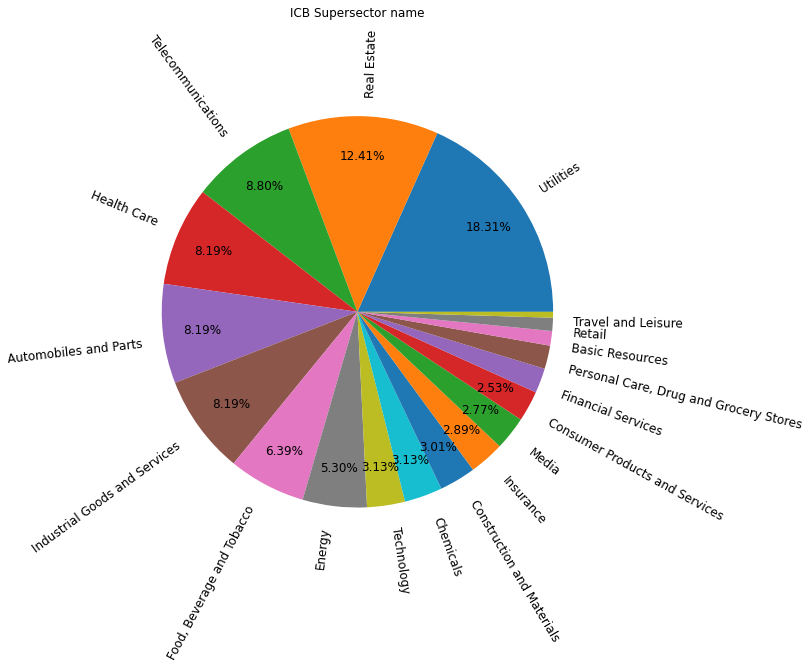

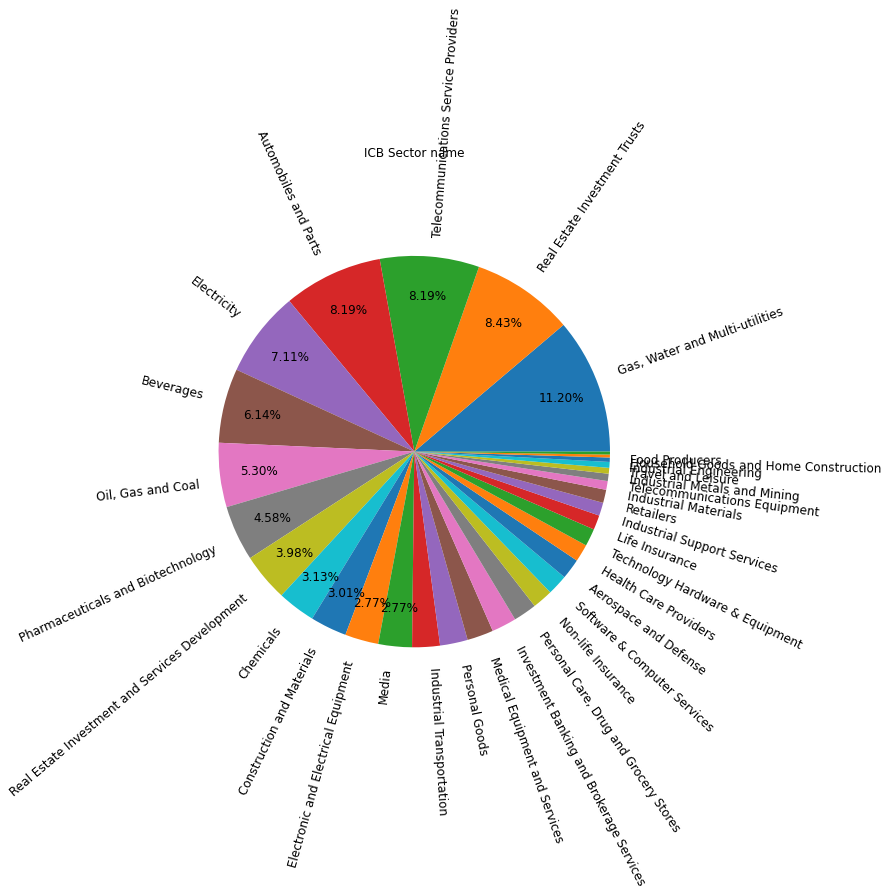

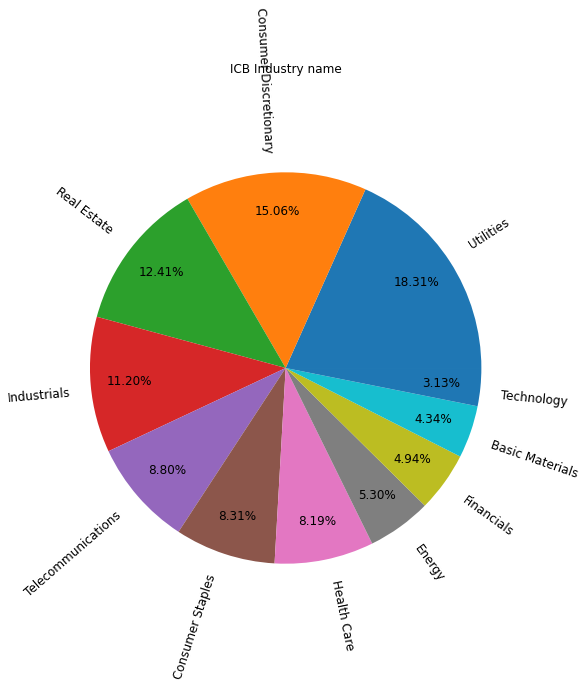

In [6]:
import matplotlib.pyplot as plt # TODO: add to requirements if used

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        if (pct > 2.4):
            return '{p:.2f}%'.format(p=pct)
        else:
            return ''
    return my_autopct

def make_pie_chart(column_name):
    fig = plt.figure(figsize=(9,9))
    ax = plt.subplot(111)

    sector_data['number']=1
    sectors = sector_data[[column_name, 'number']].groupby([column_name]).sum()
    sectors = sectors.sort_values("number", axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last', ignore_index=False, key=None)

    sectors.plot(kind='pie', y='number', ax=ax, autopct=make_autopct(sectors['number']), fontsize=12, legend=False, rotatelabels=True, pctdistance=0.8)
    plt.axis("off")
    plt.title(column_name+"\n\n\n")

make_pie_chart('ICB Supersector name')
make_pie_chart('ICB Sector name')
make_pie_chart('ICB Industry name')

# Environmental Analysis

## CO2 Data/Graphs

### Spaghetti plot CO$_2$

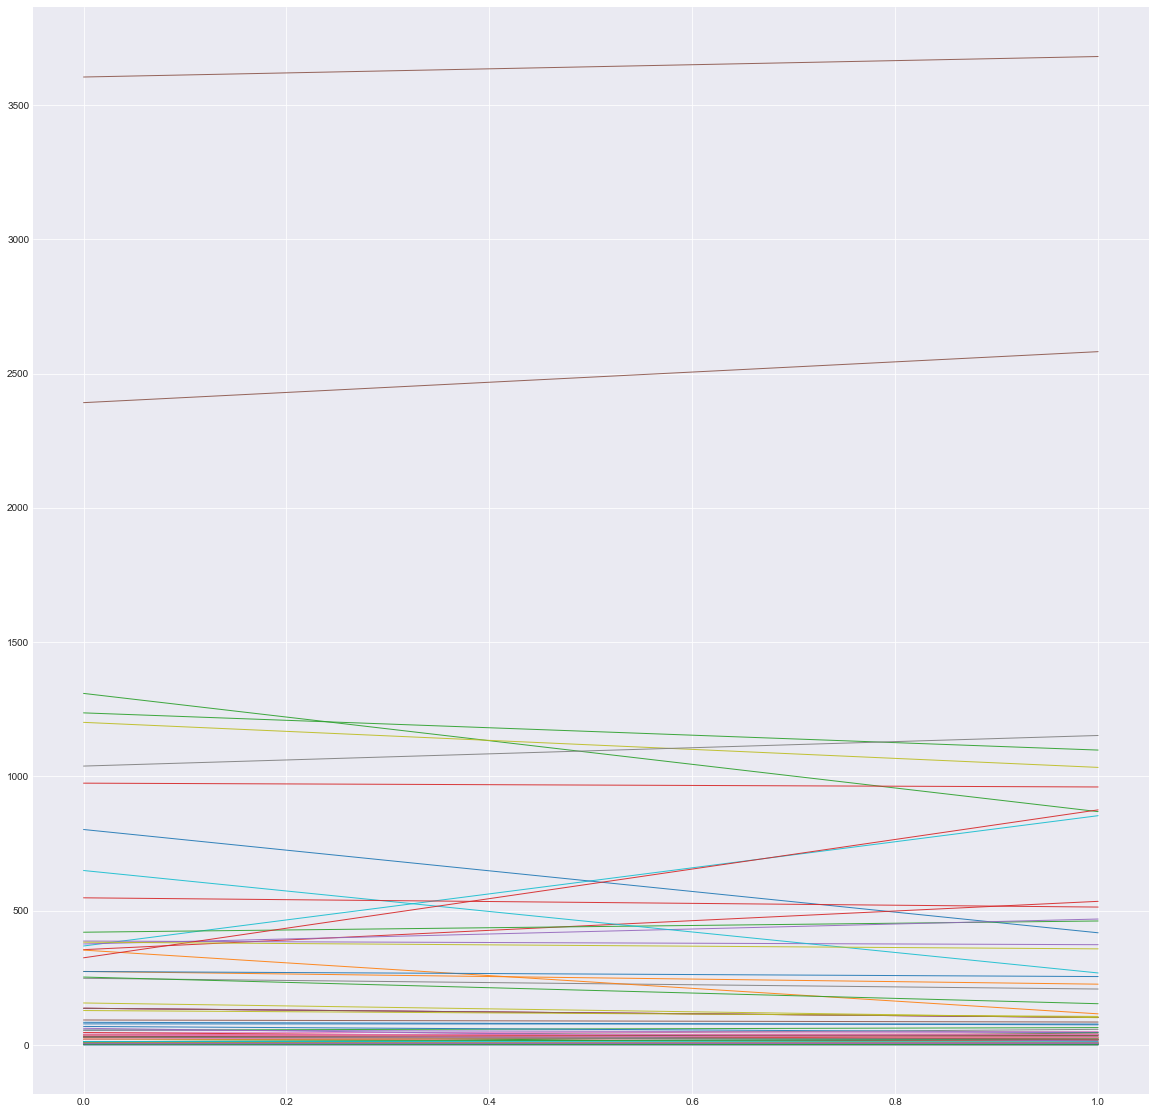

In [8]:
co2_data = eikon_data_complete[["ISSUER", "CO2", "CO2_1"]] #compnay name and CO2 subset 
company_co2_data = co2_data.drop_duplicates(subset= ["ISSUER"]) #Unique company name subset 
company_co2_data = company_co2_data[(company_co2_data.CO2 != '0') & (company_co2_data.CO2_1 != '0')] #not null value for CO2
company_co2_data = company_co2_data.reset_index() #resets index
company_co2_data = company_co2_data.drop(columns=["index"]) #removes extra column
company_co2_data = company_co2_data.replace(to_replace = '[,]', value ='.', regex=True) #making decimal points legible
company_co2_data['CO2'] =company_co2_data['CO2'].astype(float) #converting numbers to floats 
company_co2_data['CO2_1'] =company_co2_data['CO2_1'].astype(float)

#overall slope increase or decrease 
slopes = company_co2_data['CO2_1'] - company_co2_data['CO2']
slopes.sum() #shows an overall decrease in total emissions **Could cluster by sector. Hard to do anything else with 2 data points*


#making data easier to graph 
co2graph_data = company_co2_data[["CO2", "CO2_1"]]
co2graph_data = co2graph_data.transpose()
co2graph_data.insert(0, "x", [0, 1], True)


plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')

#spaghetti plot of CO2 emissions 
plt.figure(figsize=(20,20))
for column in co2graph_data.drop(columns=["x"], axis=1):
    plt.plot(co2graph_data["x"], co2graph_data[column], marker='', linewidth=1, alpha=0.9)
    
plt.show()



### Histogram change in CO$_2$

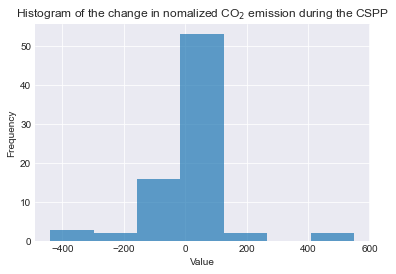

In [51]:
plt.hist(x=slopes, bins=7,alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title(r'Histogram of the change in nomalized CO$_2$ emission during the CSPP')
plt.show()

### emission of 2021 as a function of the emission in 2015

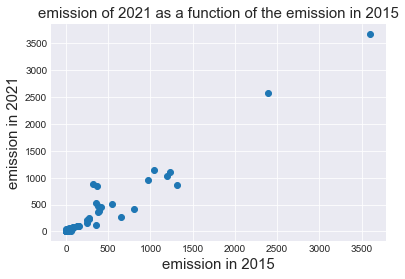

In [50]:
plt.plot(company_co2_data["CO2"],company_co2_data["CO2_1"],'o')
plt.title("emission of 2021 as a function of the emission in 2015", size=15)
plt.xlabel("emission in 2015", size=15)
plt.ylabel("emission in 2021",size=15)
plt.show()

## ESG data/plots

In [123]:
#started cleaning data as above 
esg_data = eikon_data_complete[["ISSUER", "ESG Score 2015", "ESG Score 2016", "ESG Score 2017", "ESG Score 2018", "ESG Score 2019", "ESG Score 2020", "ESG Score 2021"]]
esg_company_data = esg_data.drop_duplicates(subset= ["ISSUER"])
esg_company_data = esg_company_data.reset_index()
esg_company_data = esg_company_data.drop(columns=["index"])
esg_company_data = esg_company_data.replace(to_replace = '[,]', value ='.', regex=True)
esg_company_data = esg_company_data.replace(to_replace = "NaN", value = '0') #not sure why this doesnt work 

#converting all numbers to floats 
esg_company_data['ESG Score 2015'] = esg_company_data['ESG Score 2015'].astype(float)
esg_company_data['ESG Score 2016'] = esg_company_data['ESG Score 2016'].astype(float)
esg_company_data['ESG Score 2017'] = esg_company_data['ESG Score 2017'].astype(float)
esg_company_data['ESG Score 2018'] = esg_company_data['ESG Score 2018'].astype(float)
esg_company_data['ESG Score 2019'] = esg_company_data['ESG Score 2019'].astype(float)
esg_company_data['ESG Score 2020'] = esg_company_data['ESG Score 2020'].astype(float)
esg_company_data['ESG Score 2021'] = esg_company_data['ESG Score 2021'].astype(float)

# remove rows with no data
for index,row in esg_company_data.iterrows():
    if pd.isnull(row[1]) & (row[2]==0) & (row[3]==0) & (row[4]==0) & (row[5]==0) & (row[6]==0) & (row[7]==0):
        esg_company_data.drop(index,inplace=True)


## Spaghetti plot ESG Scores

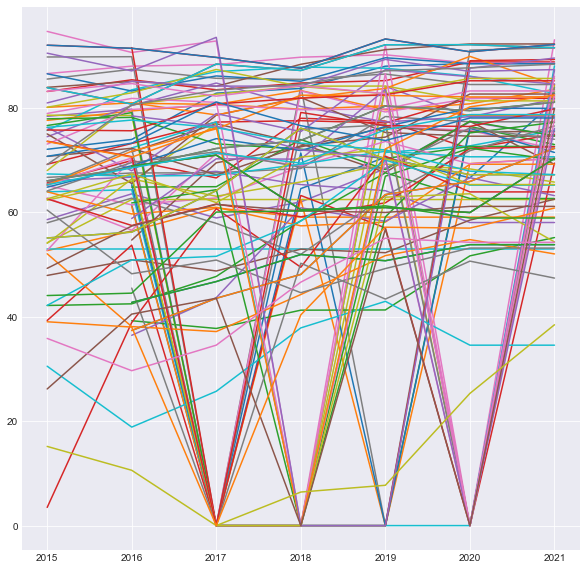

In [168]:
plt.figure(figsize=(10,10))
years = [2015,2016,2017,2018,2019,2020,2021]
for index,row in esg_company_data.iterrows():
    plt.plot(years,row[1:8])
plt.show()